In [1]:
!pip install tensorflow-ranking
!pip install tensorflow
!pip install category_encoders
!pip install rbo

In [2]:
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive')
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

import rbo
import category_encoders as ce
from sklearn.datasets import dump_svmlight_file
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import xgboost as xgb
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.impute import KNNImputer
from sklearn.model_selection import GroupShuffleSplit

from sklearn.metrics import ndcg_score

import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow_ranking as tfr
from tensorflow.keras.layers import Input, Concatenate, Embedding, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.regularizers import l2

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### STANDARD RELEVANCE SCORE
- 0 (no clicks)
- 1 (click)
- 2 (transaction)

In [3]:
X_train_pp = pd.read_csv('/content/drive/MyDrive/Expedia/allRankNew/allRank/expedia_data/Millionrows_allRank/target_relevance/train.csv')
y_train_pp = pd.read_csv('/content/drive/MyDrive/Expedia/allRankNew/allRank/expedia_data/Millionrows_allRank/target_relevance/y_train.csv')

X_val_pp = pd.read_csv('/content/drive/MyDrive/Expedia/allRankNew/allRank/expedia_data/Millionrows_allRank/target_relevance/vali.csv')
y_val_pp = pd.read_csv('/content/drive/MyDrive/Expedia/allRankNew/allRank/expedia_data/Millionrows_allRank/target_relevance/y_vali.csv')

X_test_pp = pd.read_csv('/content/drive/MyDrive/Expedia/allRankNew/allRank/expedia_data/Millionrows_allRank/target_relevance/test.csv')
y_test_pp = pd.read_csv('/content/drive/MyDrive/Expedia/allRankNew/allRank/expedia_data/Millionrows_allRank/target_relevance/y_test.csv')

### NDCG METRICS FOR THE NEURAL NETWORK

In [4]:
def ndcg_metric_30(y_true, y_pred):
    k = 30
    y_score = tf.squeeze(y_pred, axis=-1)
    y_true = tf.squeeze(y_true, axis=-1)

    order = tf.argsort(y_score, direction='DESCENDING')
    y_true_sorted = tf.gather(y_true, order)

    gain = tf.pow(2.0, y_true_sorted) - 1.0
    discounts = tf.math.log(tf.range(tf.shape(y_true_sorted)[0], dtype=tf.float32) + 2.0) / tf.math.log(2.0)

    dcg = tf.reduce_sum(gain / discounts)

    ideal_order = tf.argsort(y_true, direction='DESCENDING')
    ideal_y_true = tf.gather(y_true, ideal_order)[:k]
    ideal_gain = tf.pow(2.0, ideal_y_true) - 1.0
    ideal_dcg = tf.reduce_sum(ideal_gain / discounts[:tf.shape(ideal_gain)[0]])

    ndcg = tf.where(tf.equal(ideal_dcg, 0), 0.0, dcg / ideal_dcg)
    return ndcg

In [5]:
def ndcg_metric_20(y_true, y_pred):
    k = 20
    y_score = tf.squeeze(y_pred, axis=-1)
    y_true = tf.squeeze(y_true, axis=-1)

    order = tf.argsort(y_score, direction='DESCENDING')
    y_true_sorted = tf.gather(y_true, order)

    gain = tf.pow(2.0, y_true_sorted) - 1.0
    discounts = tf.math.log(tf.range(tf.shape(y_true_sorted)[0], dtype=tf.float32) + 2.0) / tf.math.log(2.0)

    dcg = tf.reduce_sum(gain / discounts)

    ideal_order = tf.argsort(y_true, direction='DESCENDING')
    ideal_y_true = tf.gather(y_true, ideal_order)[:k]
    ideal_gain = tf.pow(2.0, ideal_y_true) - 1.0
    ideal_dcg = tf.reduce_sum(ideal_gain / discounts[:tf.shape(ideal_gain)[0]])

    ndcg = tf.where(tf.equal(ideal_dcg, 0), 0.0, dcg / ideal_dcg)
    return ndcg

In [6]:
def ndcg_metric_10(y_true, y_pred):
    k = 10
    y_score = tf.squeeze(y_pred, axis=-1)
    y_true = tf.squeeze(y_true, axis=-1)

    order = tf.argsort(y_score, direction='DESCENDING')
    y_true_sorted = tf.gather(y_true, order)

    gain = tf.pow(2.0, y_true_sorted) - 1.0
    discounts = tf.math.log(tf.range(tf.shape(y_true_sorted)[0], dtype=tf.float32) + 2.0) / tf.math.log(2.0)

    dcg = tf.reduce_sum(gain / discounts)

    ideal_order = tf.argsort(y_true, direction='DESCENDING')
    ideal_y_true = tf.gather(y_true, ideal_order)[:k]
    ideal_gain = tf.pow(2.0, ideal_y_true) - 1.0
    ideal_dcg = tf.reduce_sum(ideal_gain / discounts[:tf.shape(ideal_gain)[0]])

    ndcg = tf.where(tf.equal(ideal_dcg, 0), 0.0, dcg / ideal_dcg)
    return ndcg

In [7]:
def ndcg_metric_5(y_true, y_pred):
    k = 5
    y_score = tf.squeeze(y_pred, axis=-1)
    y_true = tf.squeeze(y_true, axis=-1)

    order = tf.argsort(y_score, direction='DESCENDING')
    y_true_sorted = tf.gather(y_true, order)

    gain = tf.pow(2.0, y_true_sorted) - 1.0
    discounts = tf.math.log(tf.range(tf.shape(y_true_sorted)[0], dtype=tf.float32) + 2.0) / tf.math.log(2.0)

    dcg = tf.reduce_sum(gain / discounts)

    ideal_order = tf.argsort(y_true, direction='DESCENDING')
    ideal_y_true = tf.gather(y_true, ideal_order)[:k]
    ideal_gain = tf.pow(2.0, ideal_y_true) - 1.0
    ideal_dcg = tf.reduce_sum(ideal_gain / discounts[:tf.shape(ideal_gain)[0]])

    ndcg = tf.where(tf.equal(ideal_dcg, 0), 0.0, dcg / ideal_dcg)
    return ndcg

### NEURAL NETWORK ARCHITECTURE

In [8]:
query_id_train_pp = X_train_pp['qid']
query_id_val_pp = X_val_pp['qid']
query_id_test_pp = X_test_pp['qid']


X_train_2_pp = X_train_pp.drop(columns=['qid'])
X_train_arr_pp = X_train_2_pp.values.astype(float)

X_val_2_pp = X_val_pp.drop(columns=['qid'])
X_val_arr_pp = X_val_2_pp.values.astype(float)

X_test_2_pp = X_test_pp.drop(columns=['qid'])
X_test_arr_pp = X_test_2_pp.values.astype(float)


y_train_array_pp = y_train_pp.values.astype(int).ravel()
y_train_array_pp = y_train_array_pp.flatten().astype(float)

y_val_array_pp = y_val_pp.values.astype(int).ravel()
y_val_array_pp = y_val_array_pp.flatten().astype(float)

y_test_array_pp = y_test_pp.values.astype(int).ravel()
y_test_array_pp = y_test_array_pp.flatten().astype(float)

In [ ]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True, monitor='val_ndcg_metric_5', mode='max')

np.random.seed(42)
tf.random.set_seed(42)

# Input layers for features and search_id
input_features = Input(shape=(X_train_arr_pp.shape[1],), name='features')
input_query_id = Input(shape=(1,), name='search_id')

# Embedding or concatenation layer for search_id
concatenated_inputs = Concatenate()([input_features, input_query_id])

# Define the rest of your model architecture
dense_layer_1 = Dense(128, activation='relu')(concatenated_inputs)
batch_norm_1 = BatchNormalization()(dense_layer_1)
dense_layer_2 = Dense(512, activation='relu')(dense_layer_1)
dropout_layer = Dropout(0.3)(dense_layer_2)
dense_layer_3 = Dense(1024, activation='relu')(dense_layer_2)
dropout_layer = Dropout(0.3)(dense_layer_3)
dense_layer_4 = Dense(512, activation='relu')(dense_layer_3)
dense_layer_5 = Dense(256, activation='relu')(dense_layer_4)
dense_layer_6 = Dense(128, activation='relu')(dense_layer_5)
dense_layer_7 = Dense(64, activation='relu')(dense_layer_6)
dense_layer_8 = Dense(32, activation='relu')(dense_layer_7)
output_layer = Dense(1)(dense_layer_8)

#Losses
loss_ndcgapprox = tfr.keras.losses.ApproxNDCGLoss(temperature=0.1)
loss_clickeml = tfr.keras.losses.ClickEMLoss()

#Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Define the model
model = Model(inputs=[input_features, input_query_id], outputs=output_layer)

# Compile the model
model.compile(optimizer=optimizer, loss=loss_ndcgapprox, metrics=[ndcg_metric_30, ndcg_metric_20, ndcg_metric_10, ndcg_metric_5])

# Fit the model with both features and search_id
history = model.fit({'features': X_train_arr_pp, 'search_id': query_id_train_pp}, y_train_array_pp,
                    epochs=50, validation_data=({'features': X_val_arr_pp, 'search_id': query_id_val_pp}, y_val_array_pp),
                    verbose=True, batch_size=64, callbacks=[early_stopping_cb])

### NDCG COMPUTATION FOR PREDICTIONS

In [60]:
def ndcg(y_score, y_true, k):
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])

    gain = 2 ** y_true - 1

    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gain / discounts)

In [12]:
y_test_pred = y_test_pp['relevance']
query_id_test_pp = X_test_pp['qid']
qids = np.unique(query_id_test_pp)

ndcg_5 = list()
ndcg_10 = list()
ndcg_20 = list()
ndcg_30 = list()
predict_values = list()

for i, qid in tqdm(enumerate(qids[:]), total=len(qids)):
    query_id_test_pp = X_test_pp['qid']
    y = y_test_pred[query_id_test_pp == qid]

    if np.sum(y) == 0:
        continue

    X_test_2_pp = X_test_pp[X_test_pp['qid'] == qid]

    query_id_test_pp = X_test_2_pp['qid']

    X_test_2_pp = X_test_2_pp.drop(columns=['qid'])
    X_test_arr_pp = X_test_2_pp.values.astype(float)

    predictions = model.predict({'features': X_test_arr_pp, 'search_id': query_id_test_pp}, verbose=False)
    predictions = predictions.flatten()
    predict_values.append([predictions])

    for i in [5,10,20,30]:
      idcg = ndcg(y, y, k=i)
      eval(f"ndcg_{i}").append(ndcg(predictions, y, k=i) / idcg)


print(f'NDCG K5 {np.mean(ndcg_5)}')
print(f'NDCG K10 {np.mean(ndcg_10)}')
print(f'NDCG K20 {np.mean(ndcg_20)}')
print(f'NDCG K30 {np.mean(ndcg_30)}')

100%|██████████| 12779/12779 [20:54<00:00, 10.18it/s]

NDCG K5 0.09189581456145615
NDCG K10 0.13087893332724962
NDCG K20 0.2064624696367247
NDCG K30 0.3175791924342896


In [61]:
unique_qid = X_test_pp['qid'].unique()
testtt = X_test_pp[X_test_pp['qid'].isin(unique_qid[:5000])]
testtt.shape[0]
t_testtt = y_test_pp[:testtt.shape[0]]

115181

In [19]:
y_test_pred = t_testtt['relevance']
query_id_test_pp = testtt['qid']
qids = np.unique(query_id_test_pp)

ndcg_5 = list()
ndcg_10 = list()
ndcg_20 = list()
ndcg_30 = list()
predict_values = list()

for i, qid in tqdm(enumerate(qids[:]), total=len(qids)):
    query_id_test_pp = testtt['qid']
    y = y_test_pred[query_id_test_pp == qid]

    if np.sum(y) == 0:
        continue

    X_test_2_pp = testtt[testtt['qid'] == qid]

    query_id_test_pp = X_test_2_pp['qid']

    X_test_2_pp = X_test_2_pp.drop(columns=['qid'])
    X_test_arr_pp = X_test_2_pp.values.astype(float)

    predictions = model.predict({'features': X_test_arr_pp, 'search_id': query_id_test_pp}, verbose=False)
    predictions = predictions.flatten()
    predict_values.append([predictions])

    for i in [5,10,20,30]:
      idcg = ndcg(y, y, k=i)
      eval(f"ndcg_{i}").append(ndcg(predictions, y, k=i) / idcg)


print(f'NDCG K5 {np.mean(ndcg_5)}')
print(f'NDCG K10 {np.mean(ndcg_10)}')
print(f'NDCG K20 {np.mean(ndcg_20)}')
print(f'NDCG K30 {np.mean(ndcg_30)}')

100%|██████████| 4340/4340 [06:56<00:00, 10.41it/s]


NDCG K5 0.5110292595765948
NDCG K10 0.5657914933663625
NDCG K20 0.6131877895740369
NDCG K30 0.6251830678687013


In [64]:
scratch_nn_andcg = [0.51, 0.57, 0.61, 0.63]

### PENDING TO COMPUTE RBO

In [ ]:
s = [0.4, 0.5, 0.5, 0.3]
t = [0.6,0.7,0.7,0.5]

rbo.RankingSimilarity(np.argsort(np.array(s)).tolist(),np.argsort(np.array(t)).tolist()).rbo()

### PLOT COMPARISON

In [34]:
ks = ['K5', 'K10', 'K20', 'K30']

scratch_nn_sdg = [0.51, 0.57, 0.61, 0.63]
nn_allrank = [0.22, 0.28, 0.36, 0.42]
xgboost_ndcg = [0.562, 0.62, 0.66, 0.67]
lightgbm_ndcg = [0.57, 0.62, 0.66, 0.68]

original_df = [0.47, 0.51, 0.57, 0.61]

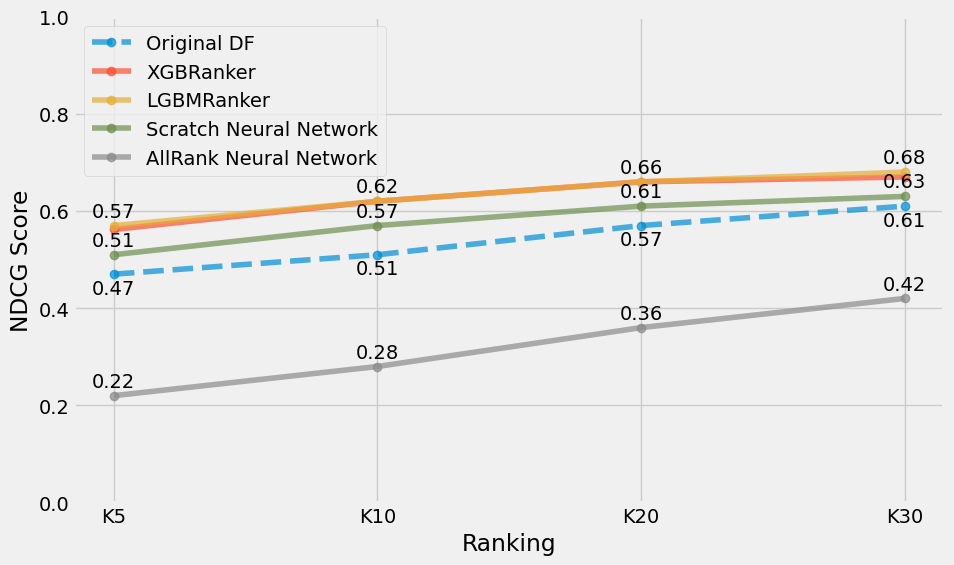

In [43]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(10,6))

plt.plot(ks, original_df, label='Original DF', alpha=0.7, linestyle='--', marker='o')
plt.plot(ks, xgboost_ndcg, label='XGBRanker', alpha=0.7, marker='o')
plt.plot(ks, lightgbm_ndcg, label='LGBMRanker', alpha=0.7, marker='o')
plt.plot(ks, scratch_nn_sdg, label='Scratch Neural Network', alpha=0.7, marker='o')
plt.plot(ks, nn_allrank, label='AllRank Neural Network', alpha=0.7, marker='o')

for i, (x, y) in enumerate(zip(ks, original_df)):
    plt.text(x, y-0.01, f'{y:.2f}', ha='center', va='top')

#for i, (x, y) in enumerate(zip(ks, xgboost_ndcg)):
 #   plt.text(x, y+0.01, f'{y:.2f}', ha='center', va='bottom')

for i, (x, y) in enumerate(zip(ks, lightgbm_ndcg)):
    plt.text(x, y+0.01, f'{y:.2f}', ha='center', va='bottom')

for i, (x, y) in enumerate(zip(ks, scratch_nn_sdg)):
    plt.text(x, y+0.01, f'{y:.2f}', ha='center', va='bottom')

for i, (x, y) in enumerate(zip(ks, nn_allrank)):
    plt.text(x, y+0.01, f'{y:.2f}', ha='center', va='bottom')

plt.title('')
plt.ylabel('NDCG Score')
plt.xlabel('Ranking')
plt.legend(loc='upper left')
plt.ylim(0,1)
plt.show()

### PRICE_BUCKET RELEVANCE SCORE
Adding to the traditional relevance score, 1 if price bucket is between 1-3, and 2 if 4-5

In [ ]:
X_train_pp = pd.read_csv('/content/drive/MyDrive/Expedia/allRankNew/allRank/expedia_data/Millionrows_allRank/target_relevance/train.csv')
y_train_pp = pd.read_csv('/content/drive/MyDrive/Expedia/allRankNew/allRank/expedia_data/Millionrows_allRank/target_relevance/y_train.csv')

X_val_pp = pd.read_csv('/content/drive/MyDrive/Expedia/allRankNew/allRank/expedia_data/Millionrows_allRank/target_relevance/vali.csv')
y_val_pp = pd.read_csv('/content/drive/MyDrive/Expedia/allRankNew/allRank/expedia_data/Millionrows_allRank/target_relevance/y_vali.csv')

X_test_pp = pd.read_csv('/content/drive/MyDrive/Expedia/allRankNew/allRank/expedia_data/Millionrows_allRank/target_relevance/test.csv')
y_test_pp = pd.read_csv('/content/drive/MyDrive/Expedia/allRankNew/allRank/expedia_data/Millionrows_allRank/target_relevance/y_test.csv')

In [ ]:
query_id_train_pp = X_train_pp['qid']
query_id_val_pp = X_val_pp['qid']
query_id_test_pp = X_test_pp['qid']


X_train_2_pp = X_train_pp.drop(columns=['qid'])
X_train_arr_pp = X_train_2_pp.values.astype(float)

X_val_2_pp = X_val_pp.drop(columns=['qid'])
X_val_arr_pp = X_val_2_pp.values.astype(float)

X_test_2_pp = X_test_pp.drop(columns=['qid'])
X_test_arr_pp = X_test_2_pp.values.astype(float)


y_train_array_pp = y_train_pp.values.astype(int).ravel()
y_train_array_pp = y_train_array_pp.flatten().astype(float)

y_val_array_pp = y_val_pp.values.astype(int).ravel()
y_val_array_pp = y_val_array_pp.flatten().astype(float)

y_test_array_pp = y_test_pp.values.astype(int).ravel()
y_test_array_pp = y_test_array_pp.flatten().astype(float)

In [ ]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True, monitor='val_ndcg_metric_5', mode='max')

np.random.seed(42)
tf.random.set_seed(42)

# Input layers for features and search_id
input_features = Input(shape=(X_train_arr_pp.shape[1],), name='features')
input_query_id = Input(shape=(1,), name='search_id')

# Embedding or concatenation layer for search_id
concatenated_inputs = Concatenate()([input_features, input_query_id])

# Define the rest of your model architecture
dense_layer_1 = Dense(128, activation='relu')(concatenated_inputs)
batch_norm_1 = BatchNormalization()(dense_layer_1)
dense_layer_2 = Dense(512, activation='relu')(dense_layer_1)
dropout_layer = Dropout(0.3)(dense_layer_2)
dense_layer_3 = Dense(1024, activation='relu')(dense_layer_2)
dropout_layer = Dropout(0.3)(dense_layer_3)
dense_layer_4 = Dense(512, activation='relu')(dense_layer_3)
dense_layer_5 = Dense(256, activation='relu')(dense_layer_4)
dense_layer_6 = Dense(128, activation='relu')(dense_layer_5)
dense_layer_7 = Dense(64, activation='relu')(dense_layer_6)
dense_layer_8 = Dense(32, activation='relu')(dense_layer_7)
output_layer = Dense(1)(dense_layer_8)

#Losses
loss_ndcgapprox = tfr.keras.losses.ApproxNDCGLoss(temperature=0.1)
loss_clickeml = tfr.keras.losses.ClickEMLoss()

#Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Define the model
model = Model(inputs=[input_features, input_query_id], outputs=output_layer)

# Compile the model
model.compile(optimizer=optimizer, loss=loss_ndcgapprox, metrics=[ndcg_metric_30, ndcg_metric_20, ndcg_metric_10, ndcg_metric_5])

# Fit the model with both features and search_id
history = model.fit({'features': X_train_arr_pp, 'search_id': query_id_train_pp}, y_train_array_pp,
                    epochs=50, validation_data=({'features': X_val_arr_pp, 'search_id': query_id_val_pp}, y_val_array_pp),
                    verbose=True, batch_size=64, callbacks=[early_stopping_cb])

Epoch 1/50
13702/13702 [==============================] - 174s 12ms/step - loss: -0.0719 - ndcg_metric_30: 0.3614 - ndcg_metric_20: 0.3614 - ndcg_metric_10: 0.3615 - ndcg_metric_5: 0.3868 - val_loss: -0.0732 - val_ndcg_metric_30: 0.3181 - val_ndcg_metric_20: 0.3191 - val_ndcg_metric_10: 0.3260 - val_ndcg_metric_5: 0.3589
Epoch 2/50
13702/13702 [==============================] - 168s 12ms/step - loss: -0.0719 - ndcg_metric_30: 0.3614 - ndcg_metric_20: 0.3614 - ndcg_metric_10: 0.3616 - ndcg_metric_5: 0.3869 - val_loss: -0.0732 - val_ndcg_metric_30: 0.3181 - val_ndcg_metric_20: 0.3191 - val_ndcg_metric_10: 0.3260 - val_ndcg_metric_5: 0.3589
Epoch 3/50
13702/13702 [==============================] - 168s 12ms/step - loss: -0.0719 - ndcg_metric_30: 0.3613 - ndcg_metric_20: 0.3613 - ndcg_metric_10: 0.3615 - ndcg_metric_5: 0.3870 - val_loss: -0.0732 - val_ndcg_metric_30: 0.3181 - val_ndcg_metric_20: 0.3191 - val_ndcg_metric_10: 0.3260 - val_ndcg_metric_5: 0.3589
Epoch 4/50
13702/13702 [=======

In [ ]:
y_test_pred = y_test_pp['relevance']
query_id_test_pp = X_test_pp['qid']
qids = np.unique(query_id_test_pp)

ndcg_5 = list()
ndcg_10 = list()
ndcg_20 = list()
ndcg_30 = list()
predict_values = list()

for i, qid in tqdm(enumerate(qids[:]), total=len(qids)):
    query_id_test_pp = X_test_pp['qid']
    y = y_test_pred[query_id_test_pp == qid]

    if np.sum(y) == 0:
        continue

    X_test_2_pp = X_test_pp[X_test_pp['qid'] == qid]

    query_id_test_pp = X_test_2_pp['qid']

    X_test_2_pp = X_test_2_pp.drop(columns=['qid'])
    X_test_arr_pp = X_test_2_pp.values.astype(float)

    predictions = model.predict({'features': X_test_arr_pp, 'search_id': query_id_test_pp}, verbose=False)
    predictions = predictions.flatten()
    predict_values.append([predictions])

    for i in [5,10,20,30]:
      idcg = ndcg(y, y, k=i)
      eval(f"ndcg_{i}").append(ndcg(predictions, y, k=i) / idcg)


print(f'NDCG K5 {np.mean(ndcg_5)}')
print(f'NDCG K10 {np.mean(ndcg_10)}')
print(f'NDCG K20 {np.mean(ndcg_20)}')
print(f'NDCG K30 {np.mean(ndcg_30)}')

 36%|███▋      | 4649/12779 [07:22<13:13, 10.25it/s]

### REVIEW RATING - REVIEW COUNT RELEVANCE SCORE

- If relevance is not equal to 0:
    - If review count is greater than 200 and review rating is 4, sum 2
    - If review_count is greater than 200 and review rating is 5, sum 3
    - If review count is greater than 200 and review rating is 3 or below, deduct 1
    - If review count is lower than 200 but review rating is equal to 4 or 5, add 1
